# Train the ML models on the new Draco dataset

In [29]:
draco_csv_filepath = "draco-qoe-dataset/ratings.csv"
results_folder = "./results_shivi"

### From file resources.csv in the dataset

| object     | quality | fps | bitrate  |
|------------|---------|-----|----------|
| dancer     | 0       | 10  | 182.471  |
| dancer     | 0       | 15  | 273.511  |
| dancer     | 0       | 30  | 547.29   |
| dancer     | 1       | 10  | 245.245  |
| dancer     | 1       | 15  | 367.644  |
| dancer     | 1       | 30  | 735.539  |
| dancer     | 2       | 10  | 321.263  |
| dancer     | 2       | 15  | 481.527  |
| dancer     | 2       | 30  | 963.341  |
| dancer     | 3       | 10  | 405.436  |
| dancer     | 3       | 15  | 607.569  |
| dancer     | 3       | 30  | 1215.621 |
| dancer     | 4       | 10  | 807.555  |
| dancer     | 4       | 15  | 1209.734 |
| dancer     | 4       | 30  | 2420.799 |
| thaidancer | 0       | 10  | 286.915  |
| thaidancer | 0       | 15  | 430.647  |
| thaidancer | 0       | 30  | 860.277  |
| thaidancer | 1       | 10  | 358.909  |
| thaidancer | 1       | 15  | 538.603  |
| thaidancer | 1       | 30  | 1076.053 |
| thaidancer | 2       | 10  | 442.003  |
| thaidancer | 2       | 15  | 663.315  |
| thaidancer | 2       | 30  | 1325.233 |
| thaidancer | 3       | 10  | 534.643  |
| thaidancer | 3       | 15  | 802.233  |
| thaidancer | 3       | 30  | 1602.851 |
| thaidancer | 4       | 10  | 1002.921 |
| thaidancer | 4       | 15  | 1504.548 |
| thaidancer | 4       | 30  | 3006.424 |

### Control the training parameters from here

In [30]:
# CONTROL THE PROGRAM HERE
parameter_columns = ["framerate",
    #"duration",
    "qp",
    "bitrate",
    #"bpp",
    ]

In [31]:
quantization_level_to_draco_QP = {0: 8, 1: 9, 2: 10, 3: 11, 4: 16}

# these distances are in "units" and idk what that is exactly
draco_distance_map = {"near": 2.5, "medium": 4.5, "far": 8.5}

quantization_level_to_bitrate = {
    "thaidancer": {0: 860.277, 1: 1076.053, 2: 1325.233, 3: 1602.851, 4: 3006.424},
    "dancer": {0: 547.29, 1: 735.539, 2: 963.341, 3: 1215.621, 4: 2420.799},
}

bits_per_point_map = {"thaidancer": 3078782, "dancer": 2608178}

resolution_map = {
    "thaidancer": 4096,  # 4096 x 4096 x 4096 point clouds
    "dancer": 2048,  # 2048 x 2048 texture maps
}

save_subfolder_name = (lambda lst: '_'.join(lst))(parameter_columns)
print(save_subfolder_name)

framerate_qp_bitrate


In [32]:
# Remove outliers using the boxplot method
def boxplot_outlier_filter_draco(frame):
    """
    Outlier filter using interquantile range (filter below Q1 - 1.5 IQR and above Q3 + 1.5 IQR)

    :param frame: data frame
    :return: filtered frame
    """
    q1 = frame.quantile(0.25, numeric_only=True)["qoe"]
    q3 = frame.quantile(0.75, numeric_only=True)["qoe"]

    # interquantile range
    iqr = q3 - q1
    fence_low = q1 - (1.5 * iqr)
    fence_high = q3 + (1.5 * iqr)

    # filter the frame
    filtered = (frame["qoe"] >= fence_low) & (frame["qoe"] <= fence_high)
    return frame.loc[filtered]

In [33]:
import pandas as pd
import numpy as np

In [34]:
draco_df = pd.read_csv(draco_csv_filepath)
draco_df

,participant,object,distance,frame_rate,encode_method,quantization_level_index,qoe,duration,size,order
0,0,dancer,far,10,V-PCC,0,3,4451,493,22
1,0,dancer,far,10,V-PCC,1,2,4467,493,48
2,0,dancer,far,10,V-PCC,2,2,6004,493,52
3,0,dancer,far,10,V-PCC,3,3,4118,493,37
4,0,dancer,far,10,V-PCC,4,4,4370,493,11
...,...,...,...,...,...,...,...,...,...,...
12235,101,thaidancer,near,30,V-PCC,0,1,3939,491,54
12236,101,thaidancer,near,30,V-PCC,1,3,4594,491,27
12237,101,thaidancer,near,30,V-PCC,2,1,8777,491,12
12238,101,thaidancer,near,30,V-PCC,3,3,3961,491,19


### only use the draco data, dont care about VPCC

In [35]:
draco_df = draco_df[draco_df["encode_method"] == "Draco"]
draco_df

,participant,object,distance,frame_rate,encode_method,quantization_level_index,qoe,duration,size,order
10,0,dancer,far,30,Draco,0,4,4534,493,26
11,0,dancer,far,30,Draco,1,3,5034,493,49
12,0,dancer,far,30,Draco,2,5,4474,493,40
13,0,dancer,far,30,Draco,3,4,4268,493,47
14,0,dancer,far,30,Draco,4,3,4215,493,57
...,...,...,...,...,...,...,...,...,...,...
12230,101,thaidancer,near,30,Draco,0,2,4235,491,52
12231,101,thaidancer,near,30,Draco,1,3,5593,491,22
12232,101,thaidancer,near,30,Draco,2,3,3855,491,31
12233,101,thaidancer,near,30,Draco,3,3,11033,491,23


### turn the distance into integer units rather than a string

In [36]:
draco_df["distance"] = draco_df["distance"].apply(lambda dist: draco_distance_map[dist])
draco_df

/tmp/ipykernel_47917/2654992743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draco_df["distance"] = draco_df["distance"].apply(lambda dist: draco_distance_map[dist])


,participant,object,distance,frame_rate,encode_method,quantization_level_index,qoe,duration,size,order
10,0,dancer,8.5,30,Draco,0,4,4534,493,26
11,0,dancer,8.5,30,Draco,1,3,5034,493,49
12,0,dancer,8.5,30,Draco,2,5,4474,493,40
13,0,dancer,8.5,30,Draco,3,4,4268,493,47
14,0,dancer,8.5,30,Draco,4,3,4215,493,57
...,...,...,...,...,...,...,...,...,...,...
12230,101,thaidancer,2.5,30,Draco,0,2,4235,491,52
12231,101,thaidancer,2.5,30,Draco,1,3,5593,491,22
12232,101,thaidancer,2.5,30,Draco,2,3,3855,491,31
12233,101,thaidancer,2.5,30,Draco,3,3,11033,491,23


### change "frame_rate" to "framerate"

In [37]:
draco_df = draco_df.rename(columns={"frame_rate": "framerate"})
draco_df

,participant,object,distance,framerate,encode_method,quantization_level_index,qoe,duration,size,order
10,0,dancer,8.5,30,Draco,0,4,4534,493,26
11,0,dancer,8.5,30,Draco,1,3,5034,493,49
12,0,dancer,8.5,30,Draco,2,5,4474,493,40
13,0,dancer,8.5,30,Draco,3,4,4268,493,47
14,0,dancer,8.5,30,Draco,4,3,4215,493,57
...,...,...,...,...,...,...,...,...,...,...
12230,101,thaidancer,2.5,30,Draco,0,2,4235,491,52
12231,101,thaidancer,2.5,30,Draco,1,3,5593,491,22
12232,101,thaidancer,2.5,30,Draco,2,3,3855,491,31
12233,101,thaidancer,2.5,30,Draco,3,3,11033,491,23


### process the quantization level index into draco quantization_parameter

In [38]:

draco_df["qp"] = draco_df["quantization_level_index"].apply(
    lambda qp: quantization_level_to_draco_QP[qp]
)

### add a bitrate parameter based on the paper

In [39]:
draco_df["bitrate"] = draco_df.apply(
    lambda row: quantization_level_to_bitrate[row.object][row.quantization_level_index], axis=1
)

draco_df

,participant,object,distance,framerate,encode_method,quantization_level_index,qoe,duration,size,order,qp,bitrate
10,0,dancer,8.5,30,Draco,0,4,4534,493,26,8,547.290
11,0,dancer,8.5,30,Draco,1,3,5034,493,49,9,735.539
12,0,dancer,8.5,30,Draco,2,5,4474,493,40,10,963.341
13,0,dancer,8.5,30,Draco,3,4,4268,493,47,11,1215.621
14,0,dancer,8.5,30,Draco,4,3,4215,493,57,16,2420.799
...,...,...,...,...,...,...,...,...,...,...,...,...
12230,101,thaidancer,2.5,30,Draco,0,2,4235,491,52,8,860.277
12231,101,thaidancer,2.5,30,Draco,1,3,5593,491,22,9,1076.053
12232,101,thaidancer,2.5,30,Draco,2,3,3855,491,31,10,1325.233
12233,101,thaidancer,2.5,30,Draco,3,3,11033,491,23,11,1602.851


#### add bits per point as a metric as well

In [40]:
# bits per point should be calculated for 30 frames per second
# thus, total points are framerate * bits_per_point_map[object_name]

draco_df["bpp"] = draco_df.apply(
    lambda row: row.bitrate / (row.framerate * bits_per_point_map[row.object]), axis=1
)
draco_df

,participant,object,distance,framerate,encode_method,quantization_level_index,qoe,duration,size,order,qp,bitrate,bpp
10,0,dancer,8.5,30,Draco,0,4,4534,493,26,8,547.290,0.000007
11,0,dancer,8.5,30,Draco,1,3,5034,493,49,9,735.539,0.000009
12,0,dancer,8.5,30,Draco,2,5,4474,493,40,10,963.341,0.000012
13,0,dancer,8.5,30,Draco,3,4,4268,493,47,11,1215.621,0.000016
14,0,dancer,8.5,30,Draco,4,3,4215,493,57,16,2420.799,0.000031
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12230,101,thaidancer,2.5,30,Draco,0,2,4235,491,52,8,860.277,0.000009
12231,101,thaidancer,2.5,30,Draco,1,3,5593,491,22,9,1076.053,0.000012
12232,101,thaidancer,2.5,30,Draco,2,3,3855,491,31,10,1325.233,0.000014
12233,101,thaidancer,2.5,30,Draco,3,3,11033,491,23,11,1602.851,0.000017


### remove the 2d video size since we're not viewing on 2d screens

In [41]:
# draco_df = draco_df[['object','framerate', 'distance', 'quantization_parameter', 'qoe']]

draco_df = draco_df[
    ["object"] 
    + parameter_columns
    + ["qoe"]
]
draco_df

,object,framerate,qp,bitrate,qoe
10,dancer,30,8,547.290,4
11,dancer,30,9,735.539,3
12,dancer,30,10,963.341,5
13,dancer,30,11,1215.621,4
14,dancer,30,16,2420.799,3
...,...,...,...,...,...
12230,thaidancer,30,8,860.277,2
12231,thaidancer,30,9,1076.053,3
12232,thaidancer,30,10,1325.233,3
12233,thaidancer,30,11,1602.851,3


### Start processing the data to be used in the ML models

In [42]:
draco_df = draco_df[
    parameter_columns + ["qoe"]
]
# groupby column names
groupby_columns_draco = parameter_columns  # MAKE SURE GROUPBY COLUMNS DOESNT HAVE QOE!!!!

configurations_draco = draco_df.groupby(groupby_columns_draco, as_index=False)
configurations_draco

filtered_draco_df = None

# for each configuration, filter outliers
for _, frame in configurations_draco:
    filtered_draco_df = pd.concat(
        [filtered_draco_df, boxplot_outlier_filter_draco(frame)], axis=0
    )

# reset the index of the filtered dataframe
filtered_draco_df = filtered_draco_df.reset_index(drop=True)

In [43]:
# filtered_draco_df = None

# Q1 = draco_df['qoe'].quantile(0.25)
# Q3 = draco_df['qoe'].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# filtered_draco_df = draco_df[(draco_df['qoe'] >= lower_bound) & (draco_df['qoe']<= upper_bound)]


In [44]:
# replace 'qoe' with 'rate' as a column name

filtered_draco_df["rate"] = filtered_draco_df["qoe"]
filtered_draco_df = filtered_draco_df[
    parameter_columns + ["rate"]
]
filtered_draco_df

,framerate,qp,bitrate,rate
0,30,8,547.290,4
1,30,8,547.290,5
2,30,8,547.290,2
3,30,8,547.290,4
4,30,8,547.290,3
...,...,...,...,...
3006,30,16,3006.424,5
3007,30,16,3006.424,4
3008,30,16,3006.424,2
3009,30,16,3006.424,2


In [45]:
groups_draco = filtered_draco_df.groupby(groupby_columns_draco)
groups_draco

In [46]:
from sklearn import preprocessing


# fn to separate cols into training and testing data
def get_train_test_fold(groups, test_group_name):
    """
    Get train/test folds for leave-one-out cross-validation.

    :param test_group_name: the group name of the test fold
    :param normalize: normalize the data with StandardScaler
    :return: tuple with data frames (train features, train labels, test features, test labels)
    """
    training_group_keys = list(groups.groups.keys())
    training_group_keys.remove(test_group_name)
    training_groups = pd.concat(list(map(groups.get_group, training_group_keys)))

    y_train = training_groups["rate"]
    # The features must not contain the last column
    x_train = training_groups.drop("rate", axis=1)

    # single test sample from test group
    y_test = groups.get_group(test_group_name)["rate"].mean()
    x_test = groups.get_group(test_group_name).head(1).iloc[:, :-1]

    return x_train, y_train, x_test, y_test

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error

seed = 12563

classifier_models = [
    RandomForestClassifier(n_estimators=100, random_state=seed),
    LogisticRegression(C=1, penalty="l2", solver="liblinear", random_state=seed),
    GradientBoostingClassifier(
        learning_rate=0.01, max_depth=5, n_estimators=100, random_state=seed
    ),
    DecisionTreeClassifier(random_state=seed),
    MLPClassifier(
        activation="relu",
        alpha=0.01,
        hidden_layer_sizes=[10, 20],
        max_iter=200,
        solver="adam",
        random_state=seed,
    ),
]

CODECS = ["DRACO"]
GROUPS = [groups_draco]
report = None

for codec, group in zip(CODECS, GROUPS):
    print(f"Processing {codec}")
    for group_name in group.groups.keys():
        # print('Groups')
        # print(group.grouper.names)
        # print(group.groups)
        x_train, y_train, x_test, y_test = get_train_test_fold(group, group_name)

        for model in classifier_models:
            # print(f"Processing {codec} with model {model.__class__.__name__}")
            # Print unique values in y_train to see what classes exist
            # print("Unique classes in training data:", np.unique(y_train))

            model.fit(x_train, y_train)

            # result of our model is the prediction of class probabilities per voting category
            class_prob_prediction = model.predict_proba(x_test)

            # Create results with probabilities for each class
            results = pd.DataFrame(
                class_prob_prediction,
                columns=["prob_1", "prob_2", "prob_3", "prob_4", "prob_5"],
            )
            results["test_configuration"] = str(group_name)
            results["model"] = model.__class__.__name__

            # Convert back from encoded to original classes for true_mos
            results["true_mos"] = y_test + 1  # Add 1 since LabelEncoder uses 0-4

            # Calculate predicted MOS from probabilities
            results["predicted_mos"] = results.apply(
                lambda row: np.sum([(i + 1) * p for i, p in enumerate(row[:5])]), axis=1
            )
            results["mse"] = mean_squared_error(
                results["true_mos"], results["predicted_mos"]
            )

            report = pd.concat([report, results], axis=0, ignore_index=True)
    print(report)

Processing DRACO
          prob_1    prob_2    prob_3    prob_4    prob_5  test_configuration  \
0   1.973240e-01  0.283597  0.260611  0.203727  0.054740     (30, 8, 547.29)   
1   1.734500e-02  0.141542  0.297563  0.357948  0.185602     (30, 8, 547.29)   
2   1.763368e-01  0.227593  0.306696  0.190938  0.098437     (30, 8, 547.29)   
3   3.039216e-01  0.326797  0.192810  0.143791  0.032680     (30, 8, 547.29)   
4   9.742859e-02  0.200066  0.202598  0.369891  0.130017     (30, 8, 547.29)   
5   1.246576e-01  0.239016  0.285198  0.256877  0.094252    (30, 8, 860.277)   
6   1.039798e-01  0.267635  0.276053  0.271958  0.080374    (30, 8, 860.277)   
7   5.659747e-02  0.230852  0.290082  0.285146  0.137323    (30, 8, 860.277)   
8   0.000000e+00  0.196013  0.378738  0.325581  0.099668    (30, 8, 860.277)   
9   1.554114e-02  0.119396  0.266930  0.387166  0.210966    (30, 8, 860.277)   
10  1.585613e-01  0.239345  0.242565  0.265466  0.094063    (30, 9, 735.539)   
11  9.149466e-02  0.125

## Regression Models

In [48]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import mean_squared_error

In [49]:
seed = 123
# report = None

# regressor_models = [
#     KNeighborsRegressor(leaf_size=10, n_neighbors=10),
#     RandomForestRegressor(random_state=seed),
#     Ridge(random_state=seed),
#     Lasso(random_state=seed),
#     GradientBoostingRegressor(random_state=seed),
#     DecisionTreeRegressor(random_state=seed),
#     MLPRegressor(random_state=seed),
#     LinearRegression(),
#     make_pipeline(PolynomialFeatures(2), preprocessing.StandardScaler(), LinearRegression())
# ]

# Updated regressor models
regressor_models = [
    RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=seed,
    ),
    GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=seed,
    ),
    ExtraTreesRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=seed,
    ),
    LinearRegression(),
    make_pipeline(
        PolynomialFeatures(degree=2), preprocessing.RobustScaler(), Ridge(alpha=0.1)
    ),
]

for codec, group in zip(CODECS, GROUPS):
    print(f"Processing {codec}")
    for group_name in group.groups.keys():
        x_train, y_train, x_test, y_test = get_train_test_fold(group, group_name)

        for model in regressor_models:
            # Fit model
            model.fit(x_train, y_train)

            # Get predictions
            y_pred = model.predict(x_test)

            # Create results DataFrame
            results = pd.DataFrame(
                {
                    "true_mos": y_test,
                    "predicted_mos": y_pred,
                    "test_configuration": str(group_name),
                    "model": model.__class__.__name__,
                }
            )

            # results = pd.DataFrame(mos_prediction, columns =['predicted_mos'])
            # results['test_configuration'] = str(group_name)
            # results['model'] = model.__class__.__name__
            # results['true_mos'] = y_test
            # results['predicted_mos'] =float(mos_prediction[0])
            # results['mse'] = mean_squared_error(results['true_mos'], results['predicted_mos'])

            # Calculate MSE per group
            results["mse"] = mean_squared_error(
                results["true_mos"], results["predicted_mos"]
            )

            report = pd.concat([report, results], axis=0, ignore_index=True)

    print(report)

Processing DRACO
      prob_1    prob_2    prob_3    prob_4    prob_5  test_configuration  \
0   0.197324  0.283597  0.260611  0.203727  0.054740     (30, 8, 547.29)   
1   0.017345  0.141542  0.297563  0.357948  0.185602     (30, 8, 547.29)   
2   0.176337  0.227593  0.306696  0.190938  0.098437     (30, 8, 547.29)   
3   0.303922  0.326797  0.192810  0.143791  0.032680     (30, 8, 547.29)   
4   0.097429  0.200066  0.202598  0.369891  0.130017     (30, 8, 547.29)   
..       ...       ...       ...       ...       ...                 ...   
95       NaN       NaN       NaN       NaN       NaN  (30, 16, 3006.424)   
96       NaN       NaN       NaN       NaN       NaN  (30, 16, 3006.424)   
97       NaN       NaN       NaN       NaN       NaN  (30, 16, 3006.424)   
98       NaN       NaN       NaN       NaN       NaN  (30, 16, 3006.424)   
99       NaN       NaN       NaN       NaN       NaN  (30, 16, 3006.424)   

                         model  true_mos  predicted_mos       mse  
0 

## Aggregate Results

In [50]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score as R2
import math

model_performance = None

for model, group_content in report.groupby("model"):
    single_model_performance = pd.DataFrame(
        data=[
            [
                model,
                R2(group_content["true_mos"], group_content["predicted_mos"]),
                mean_squared_error(
                    group_content["true_mos"], group_content["predicted_mos"]
                ),
                math.sqrt(
                    mean_squared_error(
                        group_content["true_mos"], group_content["predicted_mos"]
                    )
                ),
                mean_absolute_error(
                    group_content["true_mos"], group_content["predicted_mos"]
                ),
            ]
        ],
        columns=["model", "r2_score", "mse", "rmse", "mae"],
    )
    model_performance = pd.concat(
        [model_performance, single_model_performance], axis=0, ignore_index=True
    )

model_performance = model_performance.sort_values(
    ["r2_score", "mse", "mae"], ascending=False
).reset_index(drop=True)
model_performance

,model,r2_score,mse,rmse,mae
0,ExtraTreesRegressor,0.600493,0.185992,0.431268,0.372834
1,GradientBoostingRegressor,0.512502,0.226957,0.476400,0.439733
2,RandomForestRegressor,0.498731,0.233368,0.483082,0.439719
3,LinearRegression,-0.011988,0.471136,0.686393,0.623578
4,Pipeline,-1.084588,0.970490,0.985134,0.584895
5,LogisticRegression,-1.383968,1.109867,1.053502,0.965706
6,GradientBoostingClassifier,-1.502673,1.165131,1.079412,0.946438
7,RandomForestClassifier,-1.532914,1.179210,1.085914,0.934663
8,MLPClassifier,-1.619750,1.219637,1.104372,0.931535
9,DecisionTreeClassifier,-1.736716,1.274091,1.128756,0.919032


In [51]:
from datetime import datetime
import os

now = datetime.now()


report_savedir = "results_shivi"    + "/model_scores/draco/"    + save_subfolder_name    + "/"
os.makedirs(report_savedir, exist_ok=True)

report.to_csv(
    report_savedir
    + "performance_per_model_SHIVI_DRACO_"
    + now.strftime("%Y%m%d_%H%M%S")
    + ".csv",
    index=False,
)
model_performance.to_csv(
    report_savedir
    + "models_scores_SHIVI_DRACO_"
    + now.strftime("%Y%m%d_%H%M%S")
    + ".csv",
    index=False,
)

DecisionTreeClassifier


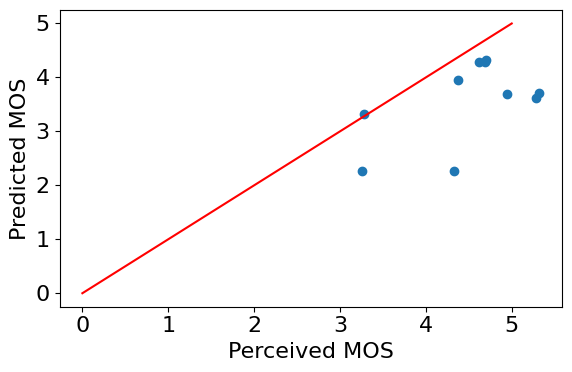

ExtraTreesRegressor


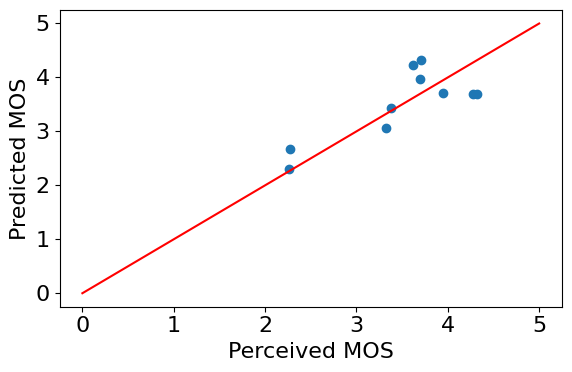

GradientBoostingClassifier


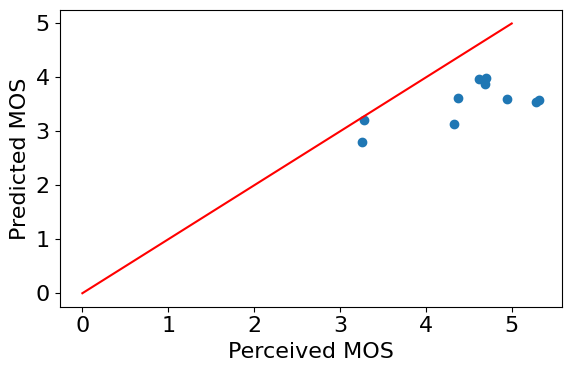

GradientBoostingRegressor


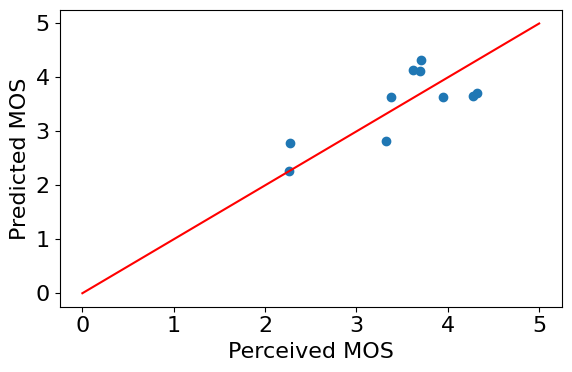

LinearRegression


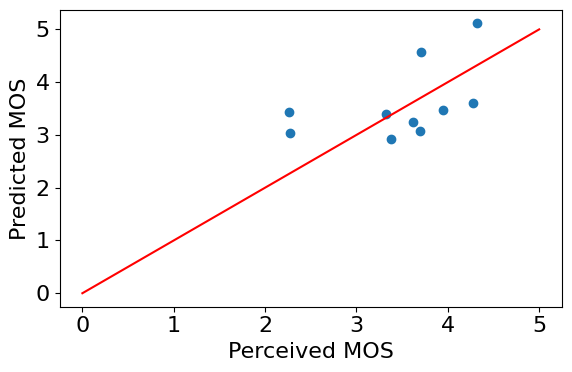

LogisticRegression


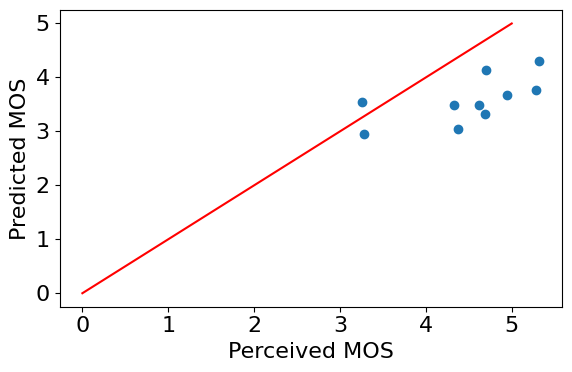

MLPClassifier


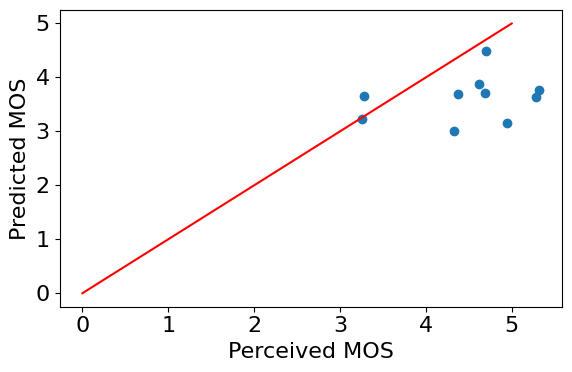

Pipeline


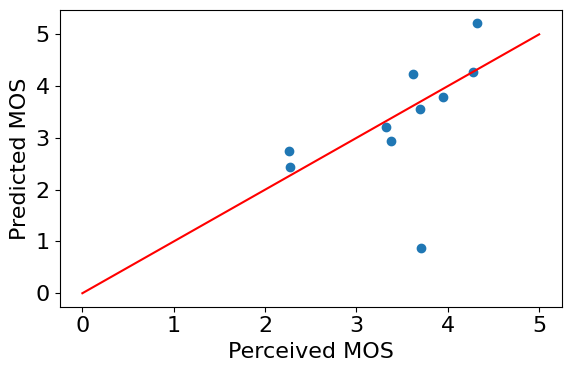

RandomForestClassifier


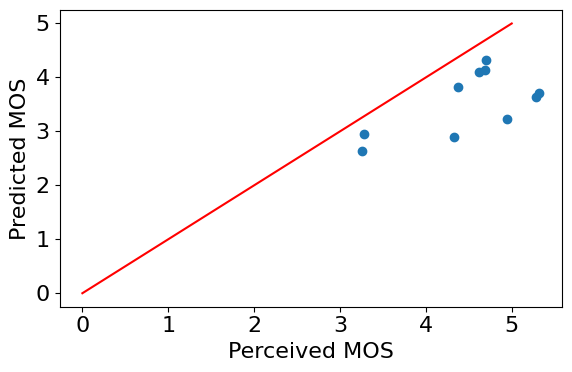

RandomForestRegressor


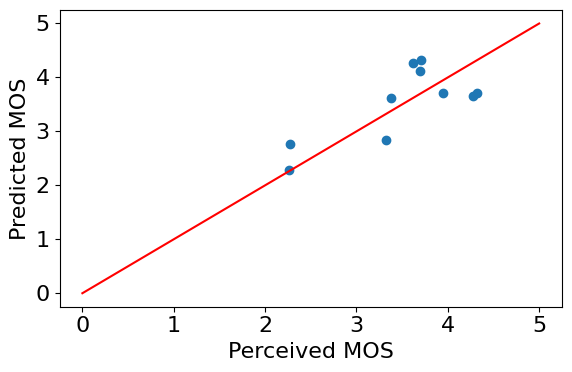

In [52]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})

figure_savedir = "./figures/"         + save_subfolder_name         + "/"
os.makedirs(figure_savedir, exist_ok=True)

for model, group_content in report.groupby("model"):
    print(model)
    # Generate the scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(group_content["true_mos"], group_content["predicted_mos"])

    # Add y=x line to the plot
    plt.plot([0, 5], [0, 5], color="red")

    # Label the axes
    plt.xlabel("Perceived MOS")
    plt.ylabel("Predicted MOS")
    plt.tight_layout()
    plt.savefig(
        figure_savedir
        +"predicted_and_true_distribution_"
        + model
        + "_DRACO_"
        + now.strftime("%Y%m%d_%H%M%S")
        + ".pdf"
    )
    plt.show()

# Use the ML Model with Partners data to generate QoE results

## Save the models using joblib

In [53]:
from joblib import dump

# After training, save all models, not just the best ones

# best_models = {}
# for model_type in ['classifier', 'regressor']:
#     model_data = model_performance[model_performance.model.str.contains(model_type, case=False)]
#     best_model_name = model_data.sort_values('rmse', ascending=True).iloc[0]['model']
#     best_models[model_type] = best_model_name

# Create directories for saving models and scalers
import os

models_dir = "./results_shivi/trained_models/" + save_subfolder_name + "/"
os.makedirs(models_dir, exist_ok=True)

# Save all the models!
for m in classifier_models:
    # Save model
    model_path = os.path.join(
        models_dir, f"{m.__class__.__name__}_{now.strftime('%Y%m%d_%H%M%S')}.joblib"
    )
    dump(m, model_path)

    print(f"Saved {m.__class__.__name__} model to: {model_path}")


# Save all the models!
for m in regressor_models:
    # Save model
    model_path = os.path.join(
        models_dir, f"{m.__class__.__name__}_{now.strftime('%Y%m%d_%H%M%S')}.joblib"
    )
    dump(m, model_path)

    print(f"Saved {m.__class__.__name__} model to: {model_path}")

Saved RandomForestClassifier model to: ./results_shivi/trained_models/framerate_qp_bitrate/RandomForestClassifier_20250710_161712.joblib
Saved LogisticRegression model to: ./results_shivi/trained_models/framerate_qp_bitrate/LogisticRegression_20250710_161712.joblib
Saved GradientBoostingClassifier model to: ./results_shivi/trained_models/framerate_qp_bitrate/GradientBoostingClassifier_20250710_161712.joblib
Saved DecisionTreeClassifier model to: ./results_shivi/trained_models/framerate_qp_bitrate/DecisionTreeClassifier_20250710_161712.joblib
Saved MLPClassifier model to: ./results_shivi/trained_models/framerate_qp_bitrate/MLPClassifier_20250710_161712.joblib
Saved RandomForestRegressor model to: ./results_shivi/trained_models/framerate_qp_bitrate/RandomForestRegressor_20250710_161712.joblib
Saved GradientBoostingRegressor model to: ./results_shivi/trained_models/framerate_qp_bitrate/GradientBoostingRegressor_20250710_161712.joblib
Saved ExtraTreesRegressor model to: ./results_shivi/tra

In [54]:
print("FOR IMMEDIATE MODEL USAGE PURPOSES\n")

print("DateTime used in filename")
print(now.strftime('%Y%m%d_%H%M%S'))

print("\n")

print("Training Parameter Columns")
print(parameter_columns)


print("Save subfolder name")
print(save_subfolder_name)

FOR IMMEDIATE MODEL USAGE PURPOSES

DateTime used in filename
20250710_161712


Training Parameter Columns
['framerate', 'qp', 'bitrate']
Save subfolder name
framerate_qp_bitrate


In [ ]:
from joblib import load
import pandas as pd

model_names = [
    "RandomForestClassifier",
    "LogisticRegression",
    "GradientBoostingClassifier",
    "DecisionTreeClassifier",
    "MLPClassifier",
    "RandomForestRegressor",
    "GradientBoostingRegressor",
    "ExtraTreesRegressor",
    "LinearRegression",
    "Pipeline",
]

# CHANGE THESE FOR USAGE
model_timestamp = "20250710_161712"
# model_timestamp = now.strftime('%Y%m%d_%H%M%S')
current_model_name = "ExtraTreesRegressor"
# model_folder_name = "framerate_qp_bitratembits"
model_folder_name = "framerate_qp_bitrate"

model = load(
    f"./results_shivi/trained_models/{model_folder_name}/{current_model_name}_{model_timestamp}.joblib"
)

# Prepare new data
new_data = pd.DataFrame(
    {
        "framerate": [30],
        #"duration": [4534],
        "qp": [14],
        "bitrate": [55],
    }
)


prediction = model.predict(new_data)
print(f"Predicted MOS: {prediction[0]:.4f}")

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- bpp
